In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os.path
from torchvision.utils import save_image

In [2]:
#定义攻击的目标网络，经典的LeNet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,6,3,stride=1,padding=1),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5,stride=1,padding=1),
            nn.MaxPool2d(2,2)
        )
        self.fc = nn.Sequential(
            nn.Linear(576,120),
            nn.Linear(120,84),
            nn.Linear(84,10)
        )
    def forward(self,x):
        out = self.conv(x)
        out = out.view(out.size(0),-1)
        out = self.fc(out)
        return out

In [3]:
def train(network):

    losses = []
    iteration = 0

    epochs = 10

    for epoch in range(epochs):
        loss_sum = 0
        for i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            pred = network(X)
            loss = loss_fn(pred, y)

            loss_sum += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mean_loss = loss_sum / len(train_dataloader.dataset)
        losses.append(mean_loss)
        iteration += 1
        print(f"Epoch {epoch+1} loss: {mean_loss:>7f}")

    # 训练完毕保存最后一轮训练的模型
    torch.save(network.state_dict(), "model.pth")

    # 绘制损失函数曲线
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.plot(list(range(iteration)), losses)

In [4]:
# 数据加载
train_data = torchvision.datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = torchvision.datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

batch_size = 64

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=1)

100%|██████████| 9912422/9912422 [00:00<00:00, 87613212.97it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21063413.98it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22344573.85it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4787767.97it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



cuda:0
Epoch 1 loss: 0.022660
Epoch 2 loss: 0.005143
Epoch 3 loss: 0.003526
Epoch 4 loss: 0.002579
Epoch 5 loss: 0.002028
Epoch 6 loss: 0.001711
Epoch 7 loss: 0.001510
Epoch 8 loss: 0.001365
Epoch 9 loss: 0.001252
Epoch 10 loss: 0.001159


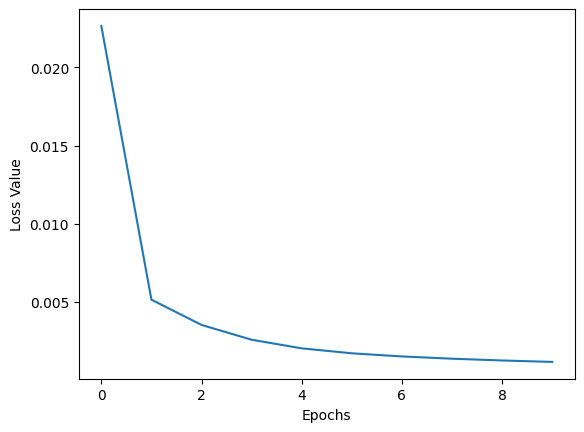

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

#训练目标网络
network = LeNet()
network.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=network.parameters(), lr=0.001, momentum=0.9)

if os.path.exists('model.pth'):
    network.load_state_dict(torch.load('model.pth'))
else:
    train(network)

In [6]:
#定义判别器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=4, stride=2, padding=0, bias=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x).squeeze()
        return output

#定义生成器 / 生成扰动
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            #input mnist 1*28*28
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            #8*26*26
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            #16*12*12
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            #output 32*5*5
        )
        
        self.bottle_neck = nn.Sequential(
            ResnetBlock(32),
            ResnetBlock(32),
            ResnetBlock(32),
            ResnetBlock(32),
        )
        self.decoder = nn.Sequential(
            #input 32*5*5
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            #16*11*11
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            #8*23*23
            nn.ConvTranspose2d(8, 1, kernel_size=6, stride=1, padding=0, bias=False),
            nn.Tanh()
            #1*28*28
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottle_neck(x)
        x = self.decoder(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type='reflect', norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [7]:
#初始化为0，0.02的正态分布更容易训练
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
#定义advGAN
class advGAN:
  def __init__(self,device,target_model):
    self.device = device
    #目标网络
    self.target_model = target_model
    #定义生成器和判别器
    self.G = Generator().to(device)
    self.D = Discriminator().to(device)
    #初始化权重
    self.G.apply(weights_init)
    self.D.apply(weights_init)
    #定义优化器
    self.optimizer_G = torch.optim.Adam(self.G.parameters(),lr=0.001,betas=(0.5, 0.999))
    self.optimizer_D = torch.optim.Adam(self.D.parameters(),lr=0.001,betas=(0.5, 0.999))
    
  #定义训练的1步
  def train_batch(self, x, labels):
    #optimize D
    perturbation = self.G(x)

    adv_images = torch.clamp(perturbation, -0.3, 0.3) + x
    adv_images = torch.clamp(adv_images, 0, 256)
    self.optimizer_D.zero_grad()
    pred_real = self.D(x)

    #判别器对真实样本的预测，希望判别真实样本为真
    loss_D_real = nn.functional.mse_loss(pred_real, torch.ones_like(pred_real,device=self.device))
    loss_D_real.backward()
    
    #判别器对扰动样本的预测，希望判别扰动样本为假
    pred_fake = self.D(adv_images.detach())
    loss_D_fake = nn.functional.mse_loss(pred_fake, torch.zeros_like(pred_fake,device=self.device))
    loss_D_fake.backward()

    loss_D_GAN = loss_D_fake + loss_D_real
    self.optimizer_D.step()

    #optimize G
    self.optimizer_G.zero_grad()

    #生成器则希望判别器判别扰动样本为真
    pred_fake = self.D(adv_images)
    loss_G_fake = nn.functional.mse_loss(pred_fake, torch.ones_like(pred_fake,device=self.device))
    loss_G_fake.backward(retain_graph=True)

    #计算扰动大小
    loss_perturb = torch.mean(torch.norm(perturbation.view(perturbation.shape[0], -1), 2, dim=1))

    #计算目标模型预测对抗样本的误差
    logits_model = self.target_model(adv_images)
    probs_model = nn.functional.softmax(logits_model, dim=1)
    onehot_labels = torch.eye(10, device=self.device)[labels]

    real = torch.sum(onehot_labels * probs_model, dim=1)
    other, _ = torch.max((1 - onehot_labels) * probs_model - onehot_labels * 10000, dim=1)
    zeros = torch.zeros_like(other)
    loss_adv = torch.max(real - other, zeros)
    loss_adv = torch.sum(loss_adv)
    adv_lambda = 10
    pert_lambda = 1
    
    loss_G = adv_lambda * loss_adv + pert_lambda * loss_perturb
    loss_G.backward()
    self.optimizer_G.step()

    return loss_D_GAN.item(), loss_G_fake.item(), loss_perturb.item(), loss_adv.item()

  def train(self, train_dataloader, epochs):
    for epoch in range(epochs):
      loss_D_sum = 0
      loss_G_fake_sum = 0
      loss_perturb_sum = 0
      loss_adv_sum = 0
      for i, (images, labels) in enumerate(train_dataloader, start=0):
        images, labels = images.to(self.device), labels.to(self.device)
        loss_D_batch, loss_G_fake_batch, loss_perturb_batch, loss_adv_batch =  self.train_batch(images, labels)
        loss_D_sum += loss_D_batch
        loss_G_fake_sum += loss_G_fake_batch
        loss_perturb_sum += loss_perturb_batch
        loss_adv_sum += loss_adv_batch

      num_batch = len(train_dataloader)
      print("epoch:{} loss_D_GAN:{} loss_G_fake:{} loss_perturb:{} loss_adv:{}".format(epoch+1, loss_D_sum/num_batch, loss_G_fake_sum/num_batch, loss_perturb_sum/num_batch, loss_adv_sum/num_batch))
      if (epoch+1) % 20 == 0:
          G_file_name = 'G_epoch_' + str(epoch+1) + '.pth'
          D_file_name = 'D_epoch_' + str(epoch+1) + '.pth'
          torch.save(self.G.state_dict(), G_file_name)
          torch.save(self.D.state_dict(), D_file_name)
    torch.save(self.G.state_dict(), 'G.pth')
    torch.save(self.D.state_dict(), 'D.pth')
  def load_weights(self,G_file_name,D_file_name):
    self.G.load_state_dict(torch.load(G_file_name))
    self.D.load_state_dict(torch.load(D_file_name))

In [9]:
network.eval()
advGan = advGAN(device, network)

if os.path.exists('G.pth') and os.path.exists('D.pth'):
  advGan.load_weights('G.pth','D.pth')
else:
  advGan.train(train_dataloader,40)

epoch:1 loss_D_GAN:0.18009770590303611 loss_G_fake:0.5899461915752272 loss_perturb:9.98236150426397 loss_adv:1.5789367087455446
epoch:2 loss_D_GAN:0.036631976133152874 loss_G_fake:0.8368231663063391 loss_perturb:7.5380115488699 loss_adv:0.2664028909573677
epoch:3 loss_D_GAN:0.017979713701166466 loss_G_fake:0.9029417564111478 loss_perturb:7.045496036248929 loss_adv:0.21352502055513833
epoch:4 loss_D_GAN:0.01082875596213915 loss_G_fake:0.9315637099717472 loss_perturb:6.931862717752518 loss_adv:0.1512351339337414
epoch:5 loss_D_GAN:0.008533903572335789 loss_G_fake:0.9475847332716496 loss_perturb:7.903035912178218 loss_adv:0.21702913036033797
epoch:6 loss_D_GAN:0.007959209389639333 loss_G_fake:0.9518845698980889 loss_perturb:6.209332602873031 loss_adv:0.11336918110087482
epoch:7 loss_D_GAN:0.007378126242177448 loss_G_fake:0.9602873916310797 loss_perturb:7.9364477210461715 loss_adv:0.14514182628726147
epoch:8 loss_D_GAN:0.003321402583429878 loss_G_fake:0.9702166199429966 loss_perturb:5.7276

In [10]:
#test adv GAN
adv_examples = []
attack_success = 0
for images, target in test_dataloader:
  images, target = images.to(device), target.to(device)
  perturbation = advGan.G(images)
  perturbation = torch.clamp(perturbation, -0.3, 0.3)
  adv_img = perturbation + images
  adv_img = torch.clamp(adv_img, 0, 1)
  pred_lab = torch.argmax(network(adv_img),1)
  if pred_lab != target:
    attack_success += 1
    if len(adv_examples) < 10:
      adv_examples.append((pred_lab,adv_img))
print("Attack success rate:{}".format(attack_success/len(test_dataloader)))

Attack success rate:0.9723


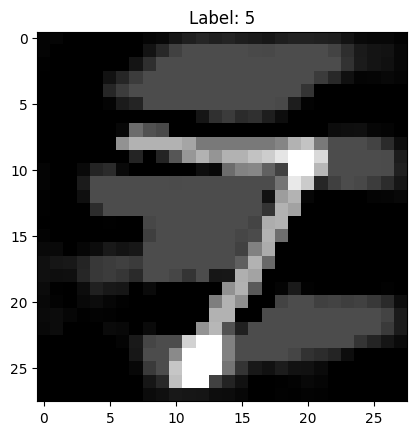

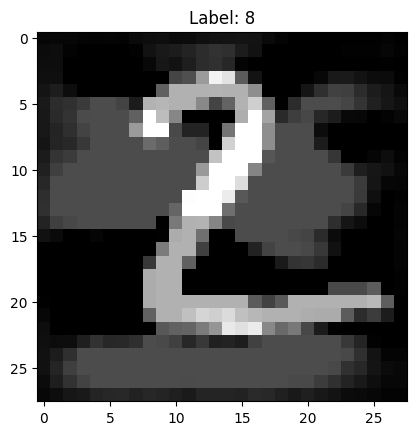

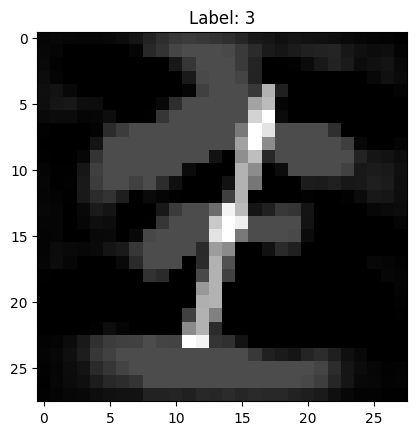

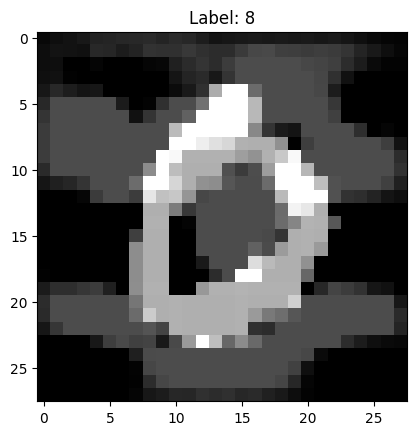

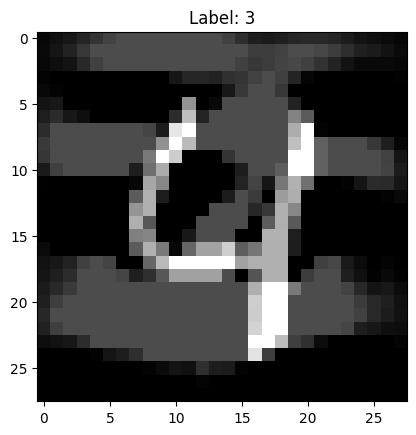

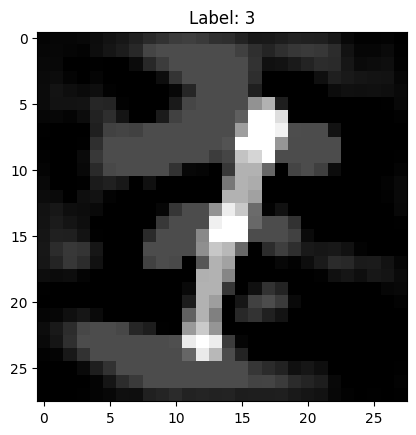

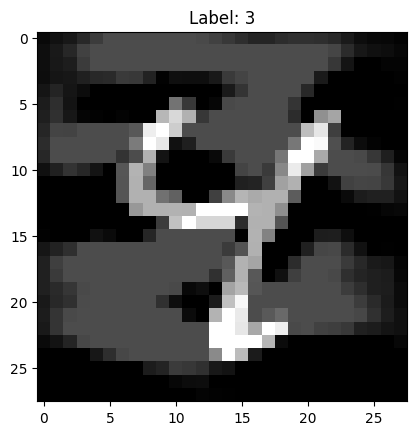

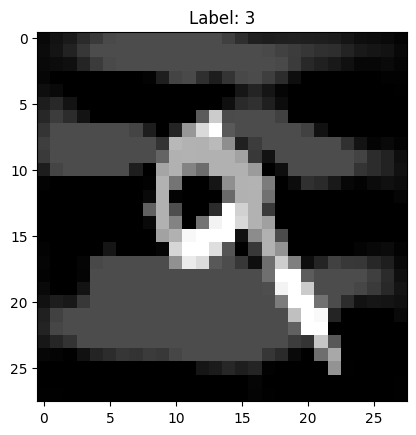

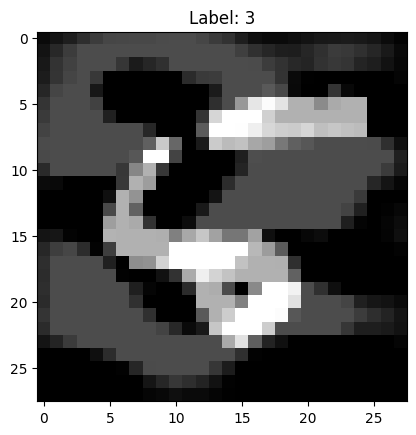

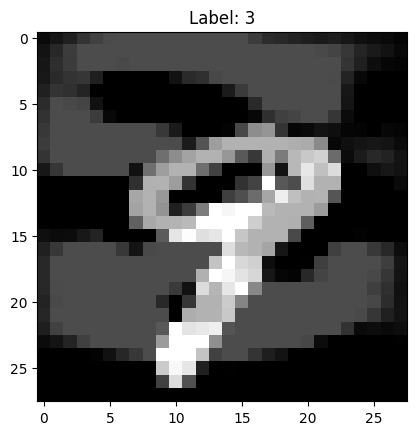

In [11]:
for i in range(len(adv_examples)):
  plt.imshow(adv_examples[i][1].cpu().detach().numpy()[0,0,:,:],cmap="gray")
  plt.title("Label: {}".format(adv_examples[i][0].cpu().detach().numpy()[0]))
  plt.show()